## Algunos astronautas dejaron olvidadas sus herramientas de trabajo fuera de la estación.
# Proponen usar al robot para localizarlas. Utilizando funciones de movilidad de la etapa anterior
# Revisar coordenadas donde los astronautas trabajaron y  mostrar en rviz la tf de las ubicaciones de tantos objetos como puedan encontrar

## El primer astronauta reporta haber trabajado en las coordenadas (1.25 , 1)
# Hay un aproximado de 4 herramientas faltantes cerca de las coordenadas


Import the required libraries and initialize them:

In [37]:
from std_srvs.srv import Empty, Trigger, TriggerRequest


In [38]:
from cv_bridge import CvBridge, CvBridgeError
import rospy
#import cv2
import ros_numpy
import numpy as np
#from tmc_tabletop_segmentator.srv import TabletopSegmentation
#from tmc_tabletop_segmentator.srv import TabletopSegmentationRequest Tmc tabletop deprecated
from sensor_msgs.msg import Image
from std_msgs.msg import String
import tf
import tf2_ros
import geometry_msgs.msg
from utils_notebooks import *


In [39]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import ros_numpy
import rospy
import tf
from gazebo_ros import gazebo_interface
from sensor_msgs.msg import LaserScan, PointCloud2
from geometry_msgs.msg import Pose, Quaternion ,TransformStamped
import moveit_commander
import moveit_msgs.msg

import sys

from utils_notebooks import *
#from utils_task1 import *
import cv2
import os

In [40]:


cv2.__version__

#

'4.5.5'

In [41]:


bridge = CvBridge()
###might take some time to load all those takeshi meshes in rviz

head = moveit_commander.MoveGroupCommander('head')
arm = moveit_commander.MoveGroupCommander('arm')
whole_body = moveit_commander.MoveGroupCommander('whole_body_light')
whole_body.set_workspace([-6.0, -6.0, 6.0, 6.0])#whole_body.go(wb)


[ WARN] [1662250579.321607833, 2990.732000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2990.762000 according to authority unknown_publisher
[ WARN] [1662250616.921185097, 3005.459000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 3005.459000 according to authority unknown_publisher
[ WARN] [1662250622.910132166, 3007.833000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2990.762000 according to authority /pose_integrator
[ WARN] [1662250622.946730950, 3007.843000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 3005.459000 according to authority /pose_integrator


In [42]:
def del_spawned(num_objs):
    for i in range (num_objs):
        delete_object('spawned'+str(i))



In [43]:
def rot_to_euler(R):
    import sys
    import math as m
    tol = sys.float_info.epsilon * 10

    if abs(R.item(0,0))< tol and abs(R.item(1,0)) < tol:
       eul1 = 0
       eul2 = m.atan2(-R.item(2,0), R.item(0,0))
       eul3 = m.atan2(-R.item(1,2), R.item(1,1))
    else:   
       eul1 = m.atan2(R.item(1,0),R.item(0,0))
       sp = m.sin(eul1)
       cp = m.cos(eul1)
       eul2 = m.atan2(-R.item(2,0),cp*R.item(0,0)+sp*R.item(1,0))
       eul3 = m.atan2(sp*R.item(0,2)-cp*R.item(1,2),cp*R.item(1,1)-sp*R.item(0,1))

    return np.asarray((eul1,eul2,eul3))
def pca_xyz(xyz):
    quats=[]
    for i in range( len(xyz)):
        pca= PCA(n_components=3).fit(xyz[i])
        vec0= pca.components_[0,:]
        vec1= pca.components_[1,:]
        vec2= pca.components_[2,:]
        R=pca.components_
        euler=rot_to_euler(R)
        quats.append(tf.transformations.quaternion_from_euler(euler[0],euler[1],euler[2]))
    return quats

In [44]:
def rot_to_euler(R):
    import sys
    tol = sys.float_info.epsilon * 10

    if abs(R.item(0,0))< tol and abs(R.item(1,0)) < tol:
       eul1 = 0
       eul2 = m.atan2(-R.item(2,0), R.item(0,0))
       eul3 = m.atan2(-R.item(1,2), R.item(1,1))
    else:   
       eul1 = m.atan2(R.item(1,0),R.item(0,0))
       sp = m.sin(eul1)
       cp = m.cos(eul1)
       eul2 = m.atan2(-R.item(2,0),cp*R.item(0,0)+sp*R.item(1,0))
       eul3 = m.atan2(sp*R.item(0,2)-cp*R.item(1,2),cp*R.item(1,1)-sp*R.item(0,1))

    return np.asarray((eul1,eul2,eul3))
def pca_xyz(xyz):
    quats=[]
    for i in range( len(xyz)):
        pca= PCA(n_components=3).fit(xyz[i])
        vec0= pca.components_[0,:]
        vec1= pca.components_[1,:]
        vec2= pca.components_[2,:]
        R=pca.components_
        euler=rot_to_euler(R)
        quats.append(tf.transformations.quaternion_from_euler(euler[0],euler[1],euler[2]))
    return quats
def static_tf_publish(cents, quaternions=[],label=''):
    if (len(quaternions))==0:
        quats=np.zeros((len(cents),4)) 
        quats[:,3]=1
        #print quats
    else:
        quats=np.asarray(quaternions)
        #print quats
    for  i ,cent  in enumerate(cents):
        x,y,z=cent
        if np.isnan(x) or np.isnan(y) or np.isnan(z):
            print('nan , rejected')
        else:
            #### first place a dissolving tf wrt head sensor  in centroids

            broadcaster.sendTransform((x,y,z),(0,0,0,1), rospy.Time.now(), 'Object'+str(i),"head_rgbd_sensor_link")
            rospy.sleep(.2)
            
            #### then place each centr wrt map
            xyz_map,cent_quat= listener.lookupTransform('/map', 'Object'+str(i),rospy.Time(0))
            map_euler=tf.transformations.euler_from_quaternion(cent_quat)
            rospy.sleep(.2)
            static_transformStamped = TransformStamped()

            ##FIXING TF TO MAP ( ODOM REALLY)    
            #tf_broadcaster1.sendTransform( (xyz[0],xyz[1],xyz[2]),tf.transformations.quaternion_from_euler(0, 0, 0), rospy.Time.now(), "obj"+str(ind), "head_rgbd_sensor_link")
            ## Finally boiradcast a static tf  in cents and with quaternion found  in pca
            if xyz_map[-1] <.2:
                static_transformStamped.header.stamp = rospy.Time.now()
                static_transformStamped.header.frame_id = "map"
                static_transformStamped.child_frame_id = "Floor_Object"+str(i)+label 
                static_transformStamped.transform.translation.x = float(xyz_map[0])
                static_transformStamped.transform.translation.y = float(xyz_map[1])
                static_transformStamped.transform.translation.z = float(xyz_map[2])
                #quat = tf.transformations.quaternion_from_euler(-euler[0],0,1.5)
                static_transformStamped.transform.rotation.x = quats [i,0]#-quat[0]#trans.transform.rotation.x
                static_transformStamped.transform.rotation.y = quats [i,1]#-quat[1]#trans.transform.rotation.y
                static_transformStamped.transform.rotation.z = quats [i,2]#-quat[2]#trans.transform.rotation.z
                static_transformStamped.transform.rotation.w = quats [i,3]#-quat[3]#trans.transform.rotation.w


                tf_static_broadcaster.sendTransform(static_transformStamped)
                print ('images[]',i)
            if    (xyz_map[-1] >.4)and (xyz_map[-1] <.5):
                static_transformStamped.header.stamp = rospy.Time.now()
                static_transformStamped.header.frame_id = "map"
                static_transformStamped.child_frame_id = "Table_Object"+str(i)+label 
                static_transformStamped.transform.translation.x = float(xyz_map[0])
                static_transformStamped.transform.translation.y = float(xyz_map[1])
                static_transformStamped.transform.translation.z = float(xyz_map[2])
                #quat = tf.transformations.quaternion_from_euler(-euler[0],0,1.5)
                static_transformStamped.transform.rotation.x = quats [i,0]#-quat[0]#trans.transform.rotation.x
                static_transformStamped.transform.rotation.y = quats [i,1]#-quat[1]#trans.transform.rotation.y
                static_transformStamped.transform.rotation.z = quats [i,2]#-quat[2]#trans.transform.rotation.z
                static_transformStamped.transform.rotation.w = quats [i,3]#-quat[3]#trans.transform.rotation.w


                tf_static_broadcaster.sendTransform(static_transformStamped)
                print ('images[]',i)
    return True


In [45]:
#!python /home/oscar/Codes/catkin_mio_ws/src/hsrb_samples/hsrb_vision_samples/src/hsrb_vision_samples/execute_tabletop_segmentation.py

In [46]:
#! python /home/oscar/Codes/catkin_mio_ws/src/hsrb_samples/hsrb_vision_samples/src/hsrb_vision_samples/execute_tabletop_segmentation_backup.py



In [47]:

rospy.init_node("recognition")


In [48]:
rgbd = RGBD()
listener = tf.TransformListener()# tf 2 to do
broadcaster= tf.TransformBroadcaster()# tf2 to do
tf_static_broadcaster= tf2_ros.StaticTransformBroadcaster()


In [49]:
def gaze_point(x,y,z):
    
    
    
    head_pose = head.get_current_joint_values()
    head_pose[0]=0.0
    head_pose[1]=0.0
    head.set_joint_value_target(head_pose)
    head.go()
    
    trans , rot = listener.lookupTransform('/map', '/head_rgbd_sensor_gazebo_frame', rospy.Time(0)) #
    
    arm_pose=arm.get_current_joint_values()
    arm_pose[0]=.1
    arm_pose[1]= -0.3
    arm.set_joint_value_target(arm_pose)
    arm.go()
    
    e =tf.transformations.euler_from_quaternion(rot)
    print('i am at',trans,np.rad2deg(e)[2])
    print('gaze goal',x,y,z)
    #tf.transformations.euler_from_quaternion(rot)


    x_rob,y_rob,z_rob,th_rob= trans[0], trans[1] ,trans[2] ,  e[2]


    D_x=x_rob-x
    D_y=y_rob-y
    D_z=z_rob-z

    D_th= np.arctan2(D_y,D_x)
    print('relative to robot',(D_x,D_y,np.rad2deg(D_th)))

    pan_correct= (- th_rob + D_th + np.pi) % (2*np.pi)

    if(pan_correct > np.pi):
        pan_correct=-2*np.pi+pan_correct
    if(pan_correct < -np.pi):
        pan_correct=2*np.pi+pan_correct

    if ((pan_correct) > .5 * np.pi):
        print ('Exorcist alert')
        pan_correct=.5*np.pi
    head_pose[0]=pan_correct
    tilt_correct=np.arctan2(D_z,np.linalg.norm((D_x,D_y)))

    head_pose [1]=-tilt_correct
    
    
    
    head.set_joint_value_target(head_pose)
    succ=head.go()
    return succ

In [50]:
clear_octo_client = rospy.ServiceProxy('/clear_octomap', Empty)

clear_octo_client.wait_for_service(timeout=1.0)


In [51]:
# initialize ROS publisher
pub = rospy.Publisher('goal', PoseStamped, queue_size=10)
goal = MoveBaseGoal()
navclient = actionlib.SimpleActionClient('/move_base/move', MoveBaseAction)
    
# wait to establish connection between the navigation interface
# move_base and navigation_log_recorder node
def move_base(goal_x,goal_y,goal_yaw,time_out=10):
    pose = PoseStamped()
    pose.header.stamp = rospy.Time.now()
    pose.header.frame_id = "map"
    pose.pose.position = Point(goal_x, goal_y, 0)
    quat = tf.transformations.quaternion_from_euler(0, 0, goal_yaw)
    pose.pose.orientation = Quaternion(*quat)


    # create a MOVE BASE GOAL
    goal = MoveBaseGoal()
    goal.target_pose = pose

    # send message to the action server
    navclient.send_goal(goal)

    # wait for the action server to complete the order
    navclient.wait_for_result(timeout=rospy.Duration(time_out))

    # print result of navigation
    action_state = navclient.get_state()
    return navclient.get_state()

In [52]:
def seg_pca(lower=2000,higher=50000,reg_ly=0,reg_hy=1000,plt_images=False): 
    image= rgbd.get_h_image()
    iimmg= rgbd.get_image()
    points_data= rgbd.get_points()
    values=image.reshape((-1,3))
    values= np.float32(values)
    criteria= (  cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER  ,1000,0.1)
    k=6
    _ , labels , cc =cv2.kmeans(values , k ,None,criteria,30,cv2.KMEANS_RANDOM_CENTERS)
    cc=np.uint8(cc)
    segmented_image= cc[labels.flatten()]
    segmented_image=segmented_image.reshape(image.shape)
    th3 = cv2.adaptiveThreshold(segmented_image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
    kernel = np.ones((5,5),np.uint8)
    im4=cv2.erode(th3,kernel,iterations=4)
    plane_mask=points_data['z']
    cv2_img=plane_mask.astype('uint8')
    img=im4
    contours, hierarchy = cv2.findContours(im4.astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    i=0
    cents=[]
    points=[]
    images=[]
    for i, contour in enumerate(contours):
        
        area = cv2.contourArea(contour)

        if area > lower and area < higher :
            M = cv2.moments(contour)
            # calculate x,y coordinate of center
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            
    
            boundRect = cv2.boundingRect(contour)
            #just for drawing rect, dont waste too much time on this
            image_aux= iimmg[boundRect[1]:boundRect[1]+boundRect[3],boundRect[0]:boundRect[0]+boundRect[2]]
            images.append(image_aux)
            img=cv2.rectangle(img,(boundRect[0], boundRect[1]),(boundRect[0]+boundRect[2], boundRect[1]+boundRect[3]), (0,0,0), 2)
            # calculate moments for each contour
            if (cY > reg_ly and cY < reg_hy  ):
                
                cv2.circle(img, (cX, cY), 5, (255, 255, 255), -1)
                cv2.putText(img, "centroid_"+str(i)+"_"+str(cX)+','+str(cY)    ,    (cX - 25, cY - 25)   ,cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 0), 2)
                print ('cX,cY',cX,cY)
                xyz=[]


                for jy in range (boundRect[0], boundRect[0]+boundRect[2]):
                    for ix in range(boundRect[1], boundRect[1]+boundRect[3]):
                        aux=(np.asarray((points_data['x'][ix,jy],points_data['y'][ix,jy],points_data['z'][ix,jy])))
                        if np.isnan(aux[0]) or np.isnan(aux[1]) or np.isnan(aux[2]):
                            'reject point'
                        else:
                            xyz.append(aux)

                xyz=np.asarray(xyz)
                cent=xyz.mean(axis=0)
                cents.append(cent)
                print (cent)
                points.append(xyz)
            else:
                print ('cent out of region... rejected')
    sub_plt=0
    if plt_images:
        for image in images:

            sub_plt+=1
            ax = plt.subplot(5, 5, sub_plt )

            plt.imshow(image)
            plt.axis("off")

    cents=np.asarray(cents)
    ### returns centroids found and a group of 3d coordinates that conform the centroid
    return(cents,np.asarray(points), images)

In [53]:
def seg_square_imgs(lower=2000,higher=50000,reg_ly=0,reg_hy=1000,reg_lx=0,reg_hx=1000,plt_images=False): 

    #Using kmeans for image segmentation find
    #Lower, higher = min, max area of the box
    #reg_ly= 30,reg_hy=600,reg_lx=0,reg_hx=1000,    Region (low  x,y  region high x,y ) Only centroids within region are accepted
    image= rgbd.get_h_image()
    iimmg= rgbd.get_image()
    points_data= rgbd.get_points()
    values=image.reshape((-1,3))
    values= np.float32(values)
    criteria= (  cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER  ,1000,0.1)
    k=6
    _ , labels , cc =cv2.kmeans(values , k ,None,criteria,30,cv2.KMEANS_RANDOM_CENTERS)
    cc=np.uint8(cc)
    segmented_image= cc[labels.flatten()]
    segmented_image=segmented_image.reshape(image.shape)
    th3 = cv2.adaptiveThreshold(segmented_image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
    kernel = np.ones((5,5),np.uint8)
    im4=cv2.erode(th3,kernel,iterations=4)
    plane_mask=points_data['z']
    cv2_img=plane_mask.astype('uint8')
    img=im4
    contours, hierarchy = cv2.findContours(im4.astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    i=0
    cents=[]
    points=[]
    images=[]
    for i, contour in enumerate(contours):

        area = cv2.contourArea(contour)

        if area > lower and area < higher :
            M = cv2.moments(contour)
            # calculate x,y coordinate of center
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])


            boundRect = cv2.boundingRect(contour)
            #just for drawing rect, dont waste too much time on this
            image_aux= iimmg[boundRect[1]:boundRect[1]+max(boundRect[3],boundRect[2]),boundRect[0]:boundRect[0]+max(boundRect[3],boundRect[2])]
            images.append(image_aux)
            img=cv2.rectangle(img,(boundRect[0], boundRect[1]),(boundRect[0]+boundRect[2], boundRect[1]+boundRect[3]), (0,0,0), 2)
            #img=cv2.rectangle(img,(boundRect[0], boundRect[1]),(boundRect[0]+max(boundRect[2],boundRect[3]), boundRect[1]+max(boundRect[2],boundRect[3])), (0,0,0), 2)
            # calculate moments for each contour
            if (cY > reg_ly and cY < reg_hy and  cX > reg_lx and cX < reg_hx   ):

                cv2.circle(img, (cX, cY), 5, (255, 255, 255), -1)
                cv2.putText(img, "centroid_"+str(i)+"_"+str(cX)+','+str(cY)    ,    (cX - 25, cY - 25)   ,cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 0), 2)
                #print ('cX,cY',cX,cY)
                xyz=[]


                for jy in range (boundRect[0], boundRect[0]+boundRect[2]):
                    for ix in range(boundRect[1], boundRect[1]+boundRect[3]):
                        aux=(np.asarray((points_data['x'][ix,jy],points_data['y'][ix,jy],points_data['z'][ix,jy])))
                        if np.isnan(aux[0]) or np.isnan(aux[1]) or np.isnan(aux[2]):
                            'reject point'
                        else:
                            xyz.append(aux)

                xyz=np.asarray(xyz)
                cent=xyz.mean(axis=0)
                cents.append(cent)
                #print (cent)
                points.append(xyz)
            else:
                #print ('cent out of region... rejected')
                images.pop()
    sub_plt=0
    if plt_images:
        for image in images:

            sub_plt+=1
            ax = plt.subplot(5, 5, sub_plt )

            plt.imshow(image)
            plt.axis("off")

    cents=np.asarray(cents)
    #images.append(img)
    return(cents,np.asarray(points), images)

In [54]:
def res_to_cents(res, plt_images=False):
    objs_depth_centroids=[]
    xyz=[]
    images=[]
    for i in range (len(res.segmented_objects_array.table_objects_array	)):
        print ( 'Plane',i,'has', len(res.segmented_objects_array.table_objects_array[i].depth_image_array), 'objects')
        for j in range (len(res.segmented_objects_array.table_objects_array[i].points_array)):
            cv2_img_depth = bridge.imgmsg_to_cv2(res.segmented_objects_array.table_objects_array[i].depth_image_array[0] )
            cv2_img = bridge.imgmsg_to_cv2(res.segmented_objects_array.table_objects_array[i].rgb_image_array[j],"rgb8" )
            pc= ros_numpy.numpify (res.segmented_objects_array.table_objects_array[i].points_array[j])
            points=np.zeros((pc.shape[0],3))
            points[:,0]=pc['x']
            points[:,1]=pc['y']
            points[:,2]=pc['z']

            points_mean=np.mean(points,axis=0)
            if np.isnan(points_mean).max():
                print('nan reject')
            else:

                objs_depth_centroids.append(points_mean)
                xyz.append(points)
                images.append(cv2_img)

    print (objs_depth_centroids)

    #lets publish a tf to this centroids ( lot of false positives) !!!!
    sub_plt=0
    if plt_images:
        for image in images:

            sub_plt+=1
            ax = plt.subplot(5, 5, sub_plt )

            plt.imshow(image)
            plt.axis("off")
    return(np.asarray(objs_depth_centroids), np.asarray(xyz),images)
        

In [55]:
arm.set_named_target('go')
arm.go()
head_val=head.get_current_joint_values()
#head_val[0]=np.deg2rad(0)
head_val[1]=np.deg2rad(-45)

head.go(head_val)
#If head didnt move, MOVE IT isnt running  properly

[ WARN] [1662250626.865920042, 3009.316000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 3009.337000 according to authority /pose_integrator
[ WARN] [1662250626.866005075, 3009.316000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 3009.337000 according to authority /pose_integrator
[ WARN] [1662250626.868526215, 3009.328000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 3009.337000 according to authority unknown_publisher
[ WARN] [1662250628.813291317, 3010.103000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 3010.144000 according to authority /pose_integrator
[ WARN] [1662250628.813355949, 3010.103000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 3010.144000 according to authority /pose_integrator
[ WARN] [1662250628.814469350, 3010.144000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

True

In [56]:


_path_model = "/home/roboworks/catkin_extras/src/tmc_wrs_gazebo_world/models"     
objs=os.listdir(_path_model)
objs.sort()


In [57]:
move_base(1.25,1.0,np.pi)
gaze_point(0.0,1.2,0.0)

[ WARN] [1662250668.440689519, 3026.006000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 3026.049000 according to authority /pose_integrator
[ WARN] [1662250668.440771255, 3026.006000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 3026.049000 according to authority /pose_integrator
[ WARN] [1662250668.452601888, 3026.049000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 3026.049000 according to authority unknown_publisher
[ WARN] [1662250686.931246894, 3033.244000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 3033.279000 according to authority /pose_integrator
[ WARN] [1662250686.931329916, 3033.244000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 3033.279000 according to authority /pose_integrator
[ WARN] [1662250686.931554081, 3033.244000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

i am at [1.3104435681151938, 0.9873574843047224, 0.9670981639207188] -179.97855085151818
gaze goal 0.0 1.2 0.0
relative to robot (1.3104435681151938, -0.2126425156952776, -9.216912069144906)


[ WARN] [1662250708.592852426, 3041.776000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 3041.776000 according to authority unknown_publisher
[ WARN] [1662250708.592950082, 3041.776000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 3041.776000 according to authority /pose_integrator
[ WARN] [1662250708.592996645, 3041.776000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 3041.776000 according to authority /pose_integrator


True

In [58]:
num_objs=3
x_gaz,y_gaz= 0,1.21


for i in range(num_objs):
    eu_i,eu_j,eu_k = np.random.rand(3)*np.pi
    spawn_object('spawned'+str(i),objs[-33], x_gaz+0.1*np.random.randn(),  y_gaz+0.1*np.random.randn(),  0.71+0.1*np.random.randn(),eu_i,eu_j,eu_k )
 


#NO GRAV
#for i in range(num_objs):
#    eu_i,eu_j,eu_k = np.random.rand(3)*np.pi
#    spawn_object('spawned'+str(i),objs[-1], x_gaz+0.1*np.random.randn(),  y_gaz+0.1*np.random.randn(),  0.71+0.1*np.random.randn(),eu_i,eu_j,eu_k )
    


[INFO] [1662250729.364128, 3049.986000]: Spawn: ycb_057_racquetball
[INFO] [1662250729.370859, 3049.986000]: Spawn: [-0.16824031  0.67658719  0.59236072  0.40377438]
[INFO] [1662250729.374868, 3049.986000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1662250729.379455, 3049.986000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1662250729.663245, 3050.071000]: Spawn status: SpawnModel: Successfully spawned entity
[INFO] [1662250729.666631, 3050.071000]: Spawn: ycb_057_racquetball
[INFO] [1662250729.672820, 3050.072000]: Spawn: [0.04440329 0.57082831 0.81547116 0.08479495]
[INFO] [1662250729.678405, 3050.075000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1662250729.685364, 3050.079000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1662250729.915711, 3050.149000]: Spawn status: SpawnModel: Successfully spawned entity
[INFO] [1662250729.923158, 3050.149000]: Spawn: ycb_057_racquetball
[INFO] [1662250729.925298, 3050.149000]: Spawn: [ 0.90005723  0.36701658 -0.153265

[ WARN] [1662250731.168762906, 3050.500000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 3050.500000 according to authority unknown_publisher
[ WARN] [1662250731.170979275, 3050.500000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 3050.500000 according to authority /pose_integrator
[ WARN] [1662250731.171088343, 3050.500000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 3050.500000 according to authority /pose_integrator


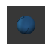

In [59]:
cents,xyz,imgs=seg_square_imgs(lower=100,plt_images=True)

In [61]:
static_tf_publish(cents,label='coords 1')

images[] 0


True

[ WARN] [1662250790.033883467, 3073.179000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 3073.179000 according to authority /pose_integrator
[ WARN] [1662250790.033984829, 3073.179000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 3073.179000 according to authority /pose_integrator
[ WARN] [1662250790.039287913, 3073.179000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 3073.179000 according to authority unknown_publisher
[ WARN] [1662250801.969911590, 3077.841000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 3077.875000 according to authority unknown_publisher
[ WARN] [1662250801.970604606, 3077.841000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 3077.875000 according to authority /pose_integrator
[ WARN] [1662250801.970657212, 3077.841000000]: TF_REPEATED_DATA ignoring data with redundant timestamp

In [ ]:
del_spawned(num_objs)

In [62]:
move_base(5.2,-2.7,0,15)

[ WARN] [1662250824.145344699, 3086.499000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 3086.499000 according to authority /pose_integrator
[ WARN] [1662250824.145502459, 3086.499000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 3086.499000 according to authority /pose_integrator
[ WARN] [1662250824.148151576, 3086.499000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 3086.499000 according to authority unknown_publisher
[ WARN] [1662250829.543642586, 3088.601000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 3088.644000 according to authority /pose_integrator
[ WARN] [1662250829.543719876, 3088.601000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 3088.644000 according to authority /pose_integrator
[ WARN] [1662250829.546200069, 3088.601000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

1

In [63]:
arm.set_named_target('go')
arm.go()

True

In [64]:
hv= head.get_current_joint_values()
hv[1]=-.7
head.go(hv)

True

/tmp/ipykernel_53100/4241381817.py:82: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(cents,np.asarray(points), images)


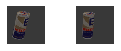

In [65]:
cents,xyz,imgs=seg_square_imgs(lower=100,plt_images=True)

In [68]:
static_tf_publish(cents, label='coords2')

images[] 0
images[] 1


True